### **2. Modelo de Optimización de Precios**

Finalizado el análisis y con las interiorizaciones obtenidas, procedemos 
a crear el modelo para la optimización de precios, donde debemos contemplar 
primero el efecto combinado de precios y cantidad. Esto debido a que nos 
guiaremos del concepto de que que ambas métricas se relacionan. Entonces:
$$
D = D_0*(\frac{P}{P_0})^e
$$
Donde
- $D$ = Demanda
- $D_0$ = Demanda pronosticada
- $P_0$ = Precio actual
- $e$ = coeficiente de elasticidad

Podemos despejar $e$ de manera que:
$$
(\frac{D}{D_0}) = (\frac{P}{P_0})^e => e = \frac{log(\frac{D}{D_0})}{log(\frac{P}{P_0})}
$$

La demanda no depende exclusivamente del precio, debido a que deberiamos 
considerar a la competencia, productos sustitutos y complementarios, etc. 

Los siguientes pasos fueron tomados en esta libreta:

1. Preparar los datos
2. Graficar el efecto de demanda por precio, asumiendo otros efectos estáticos
3. Predecir la demanda para un periodo según solicitado
4. Calcular el mejor nivel de precios y el revenue esperado

In [1]:
# Step 0. Load libraries and custom functions
# Dataframes, vectors & matrices
import pandas as pd
import numpy as np
# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Statistics
import scipy.stats as scp_stats
import statsmodels.api as sm
# Time series
import darts
from darts.models import ExponentialSmoothing

/Users/alexismena/Documents/Data_Projects/Python/Pricing_Model/.venv/lib/python3.10/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


Procederemos a la carga de los datos y a un vistazo a los mismos:

In [2]:
# Step 1. Load dataset
# 1.1 Read csv and get basic info
df_raw = pd.read_csv('../data/ventas_final.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10879 entries, 0 to 10878
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fecha_Formato     10879 non-null  object 
 1   Fecha             10879 non-null  object 
 2   Codigo            10879 non-null  int64  
 3   Descripcion       10879 non-null  object 
 4   Precio_Unitario   10879 non-null  float64
 5   Costo_Unitario    10879 non-null  float64
 6   Cantidad_Vendida  10879 non-null  float64
 7   Ganancia          10879 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 680.1+ KB


In [3]:
# 1.2 Get a sample
df_raw.sample(5, random_state=2024)

,Fecha_Formato,Fecha,Codigo,Descripcion,Precio_Unitario,Costo_Unitario,Cantidad_Vendida,Ganancia
10849,2024-02-05,2024-06,10121151,BIPACK NOSOTRAS 2 INV DEO 10UN,18.2,17.98,5.0,1.10
3320,2023-01-30,2023-05,100714,HUEVO ROLON M.CORTADO 12U,12.9,10.00,9.0,26.10
1150,2022-10-17,2022-42,10108320,CHOCOLATE SUBLIME CLASICO 100GR,12.5,12.00,1.0,0.50
7147,2022-10-24,2022-43,10000095,GASEOSA PEPSI 500ML,3.5,3.22,28.0,7.84
6449,2023-06-19,2023-25,10022018,PAPEL HIG CONFORT 12UN,74.1,63.71,5.0,51.95


Debido a que grabamos los datos en formato csv en el anterior notebook, 
debemos darle el formato y establecer el índice con las fechas.

In [15]:
# 1.3 Transform the data as in the previous notebook
df_interim = df_raw.copy()
idx = pd.DatetimeIndex(df_interim['Fecha_Formato'])
df_interim = df_interim.set_index(idx)
df_interim = df_interim.drop(columns=['Fecha_Formato'])
df_interim['Codigo'] = df_interim['Codigo'].astype(str)
df_interim.sample(5, random_state=2024)

,Fecha,Codigo,Descripcion,Precio_Unitario,Costo_Unitario,Cantidad_Vendida,Ganancia
Fecha_Formato,,,,,,,
2024-02-05,2024-06,10121151,BIPACK NOSOTRAS 2 INV DEO 10UN,18.2,17.98,5.0,1.10
2023-01-30,2023-05,100714,HUEVO ROLON M.CORTADO 12U,12.9,10.00,9.0,26.10
2022-10-17,2022-42,10108320,CHOCOLATE SUBLIME CLASICO 100GR,12.5,12.00,1.0,0.50
2022-10-24,2022-43,10000095,GASEOSA PEPSI 500ML,3.5,3.22,28.0,7.84
2023-06-19,2023-25,10022018,PAPEL HIG CONFORT 12UN,74.1,63.71,5.0,51.95


Luego tendremos nuestro dataset final

In [16]:
# 1.4 Create a copy
df = df_interim.copy()

Ahora procederemos a analizar como se comporta el precio con la demanda. 
Para ello haremos una gráfica por cada producto, y haremos una regresión 
lineal en cada uno, evaluando el índice de correlación y el p-value, el 
cual estableceremos como $\alpha$=0.05 como corte para la decisión.

Figura 1. Diagrama de demanda precio por producto


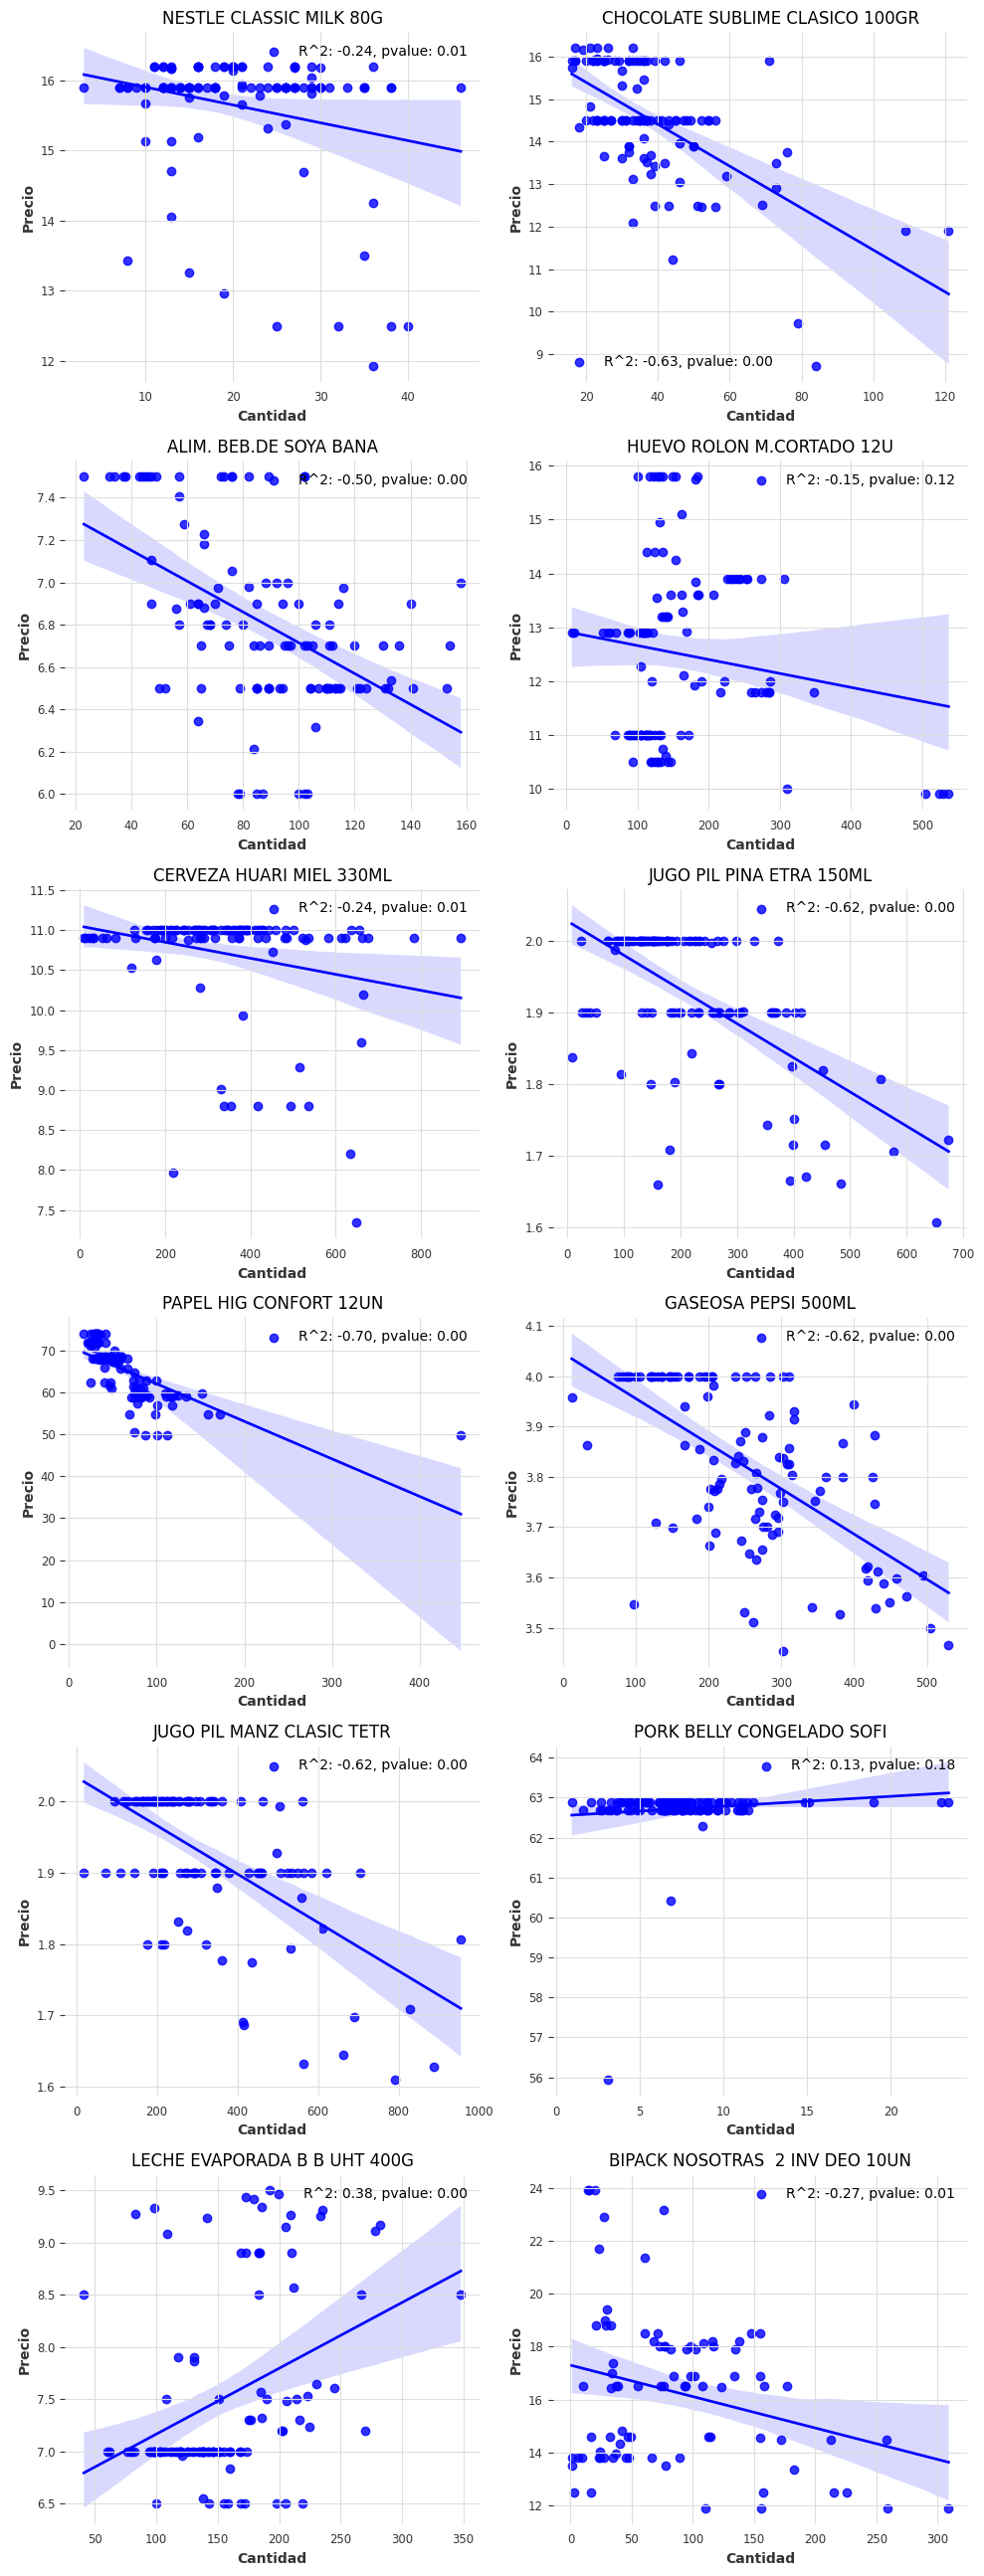

In [119]:
# Step 2. Analizar el efecto demanda precio
# 2.1 Correlación demanda-precio
print('Figura 1. Diagrama de demanda precio por producto')
elasticities = {}
intercepts = {}
categories = df['Descripcion'].unique().tolist()
fig, axs = plt.subplots(6,2,figsize=(10,26))
for i, ax in enumerate(axs.flatten()):
    temp_df = df[df['Descripcion']==categories[i]].copy()
    temp_df['QP'] = temp_df['Cantidad_Vendida'] * temp_df['Precio_Unitario']
    temp_df['Precio_Medio'] = temp_df.groupby(temp_df.index)['QP'].transform('sum') / temp_df.groupby(temp_df.index)['Cantidad_Vendida'].transform('sum')
    seg_df = temp_df.groupby(temp_df.index).\
            agg({'Cantidad_Vendida':'sum', 'Precio_Medio':'mean'})
    r, p = scp_stats.pearsonr(seg_df['Cantidad_Vendida'], seg_df['Precio_Medio'])
    res = scp_stats.linregress(seg_df['Cantidad_Vendida'], seg_df['Precio_Medio'])
    sns.regplot(x='Cantidad_Vendida', 
                y='Precio_Medio', 
                data=seg_df, 
                ax=ax, color='b', label=f'R^2: {r:.2f}, pvalue: {p:.2f}')
    ax.set_title(categories[i])
    ax.legend()
    ax.set_xlabel('Cantidad')
    ax.set_ylabel('Precio')
    elasticities[categories[i]] = res.slope
    intercepts[categories[i]] = res.intercept
plt.tight_layout()
plt.show()

En este caso la expectativa es que si el precio disminuye se incrementa 
la demanda y viceversa. Casi todos los productos tienen esa tendencia, 
excepto la panceta y la leche evaporada. Los productos con mayor correlación 
son el papel hig, el jugo pil manz., la gaseosa pepsi y el jugo pil pina. 
Aquí empieza el cuestionamiento, ya que hay productos que parecen incrementar 
la cantidad demandada conforme se incrementa el precio, sin embargo el 
coeficiente de correlación es bajo, es decir que hay un componente grande 
de varianza que no se puede explicar, como el caso de la leche evaporada.

Ahora procederemos a evaluar como se distribuyen los precios mediante un 
histograma de valores.

Figura 2. Histograma de precios de productos


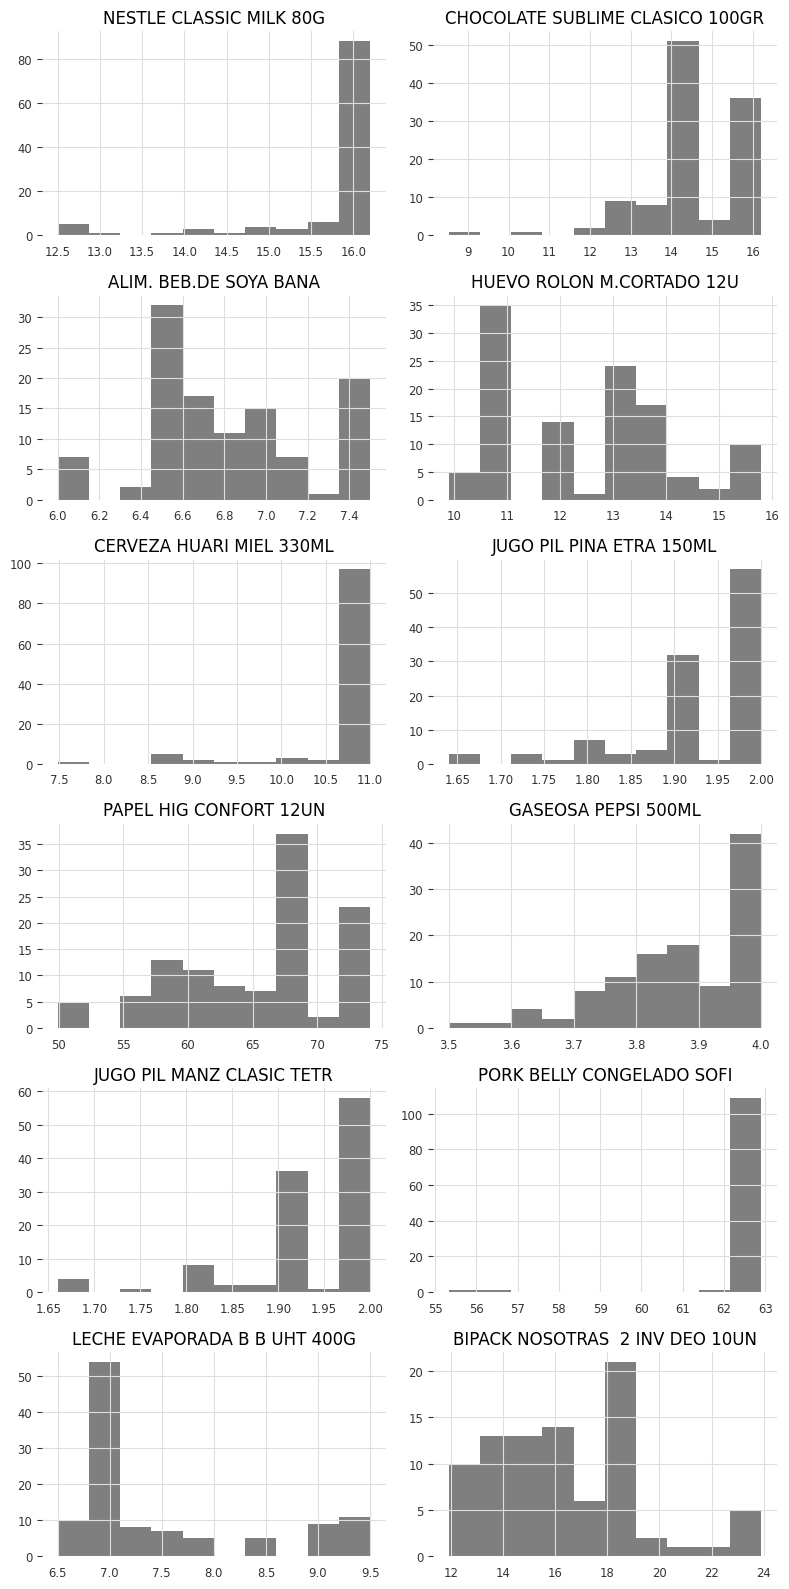

In [18]:
# 2.2 Plot price histogram
print('Figura 2. Histograma de precios de productos')
categories = df['Descripcion'].unique().tolist()
fig, axs = plt.subplots(6,2,figsize=(8,16))
for i, ax in enumerate(axs.flatten()):
    temp_df = df[df['Descripcion']==categories[i]].\
        reset_index().groupby(['Fecha_Formato']).\
            agg({'Cantidad_Vendida':'sum', 'Precio_Unitario':'mean'})
    ax.hist(temp_df['Precio_Unitario'], alpha=0.5, label='Precio')
    ax.set_title(categories[i])
plt.tight_layout()
plt.show()

En el histograma podemos corroborar lo que indicamos en el análisis, esto 
es que ciertos productos son muy estables en precio como el nestle classic 
milk, la panceta de cerdo y la cerveza huari. 

Ahora procederemos a predecir la demanda para la semana 9 del 2024, esto 
es solo un periodo. Debido a los picos de demanda observados, el criterio 
tomado fue de utilizar promedios móviles y tomar el último valor como 
pronóstico para el siguiente periodo, con ello no arriesgamos valores 
extremos.

Figura 3. Cantidad de producto vendido, por semana


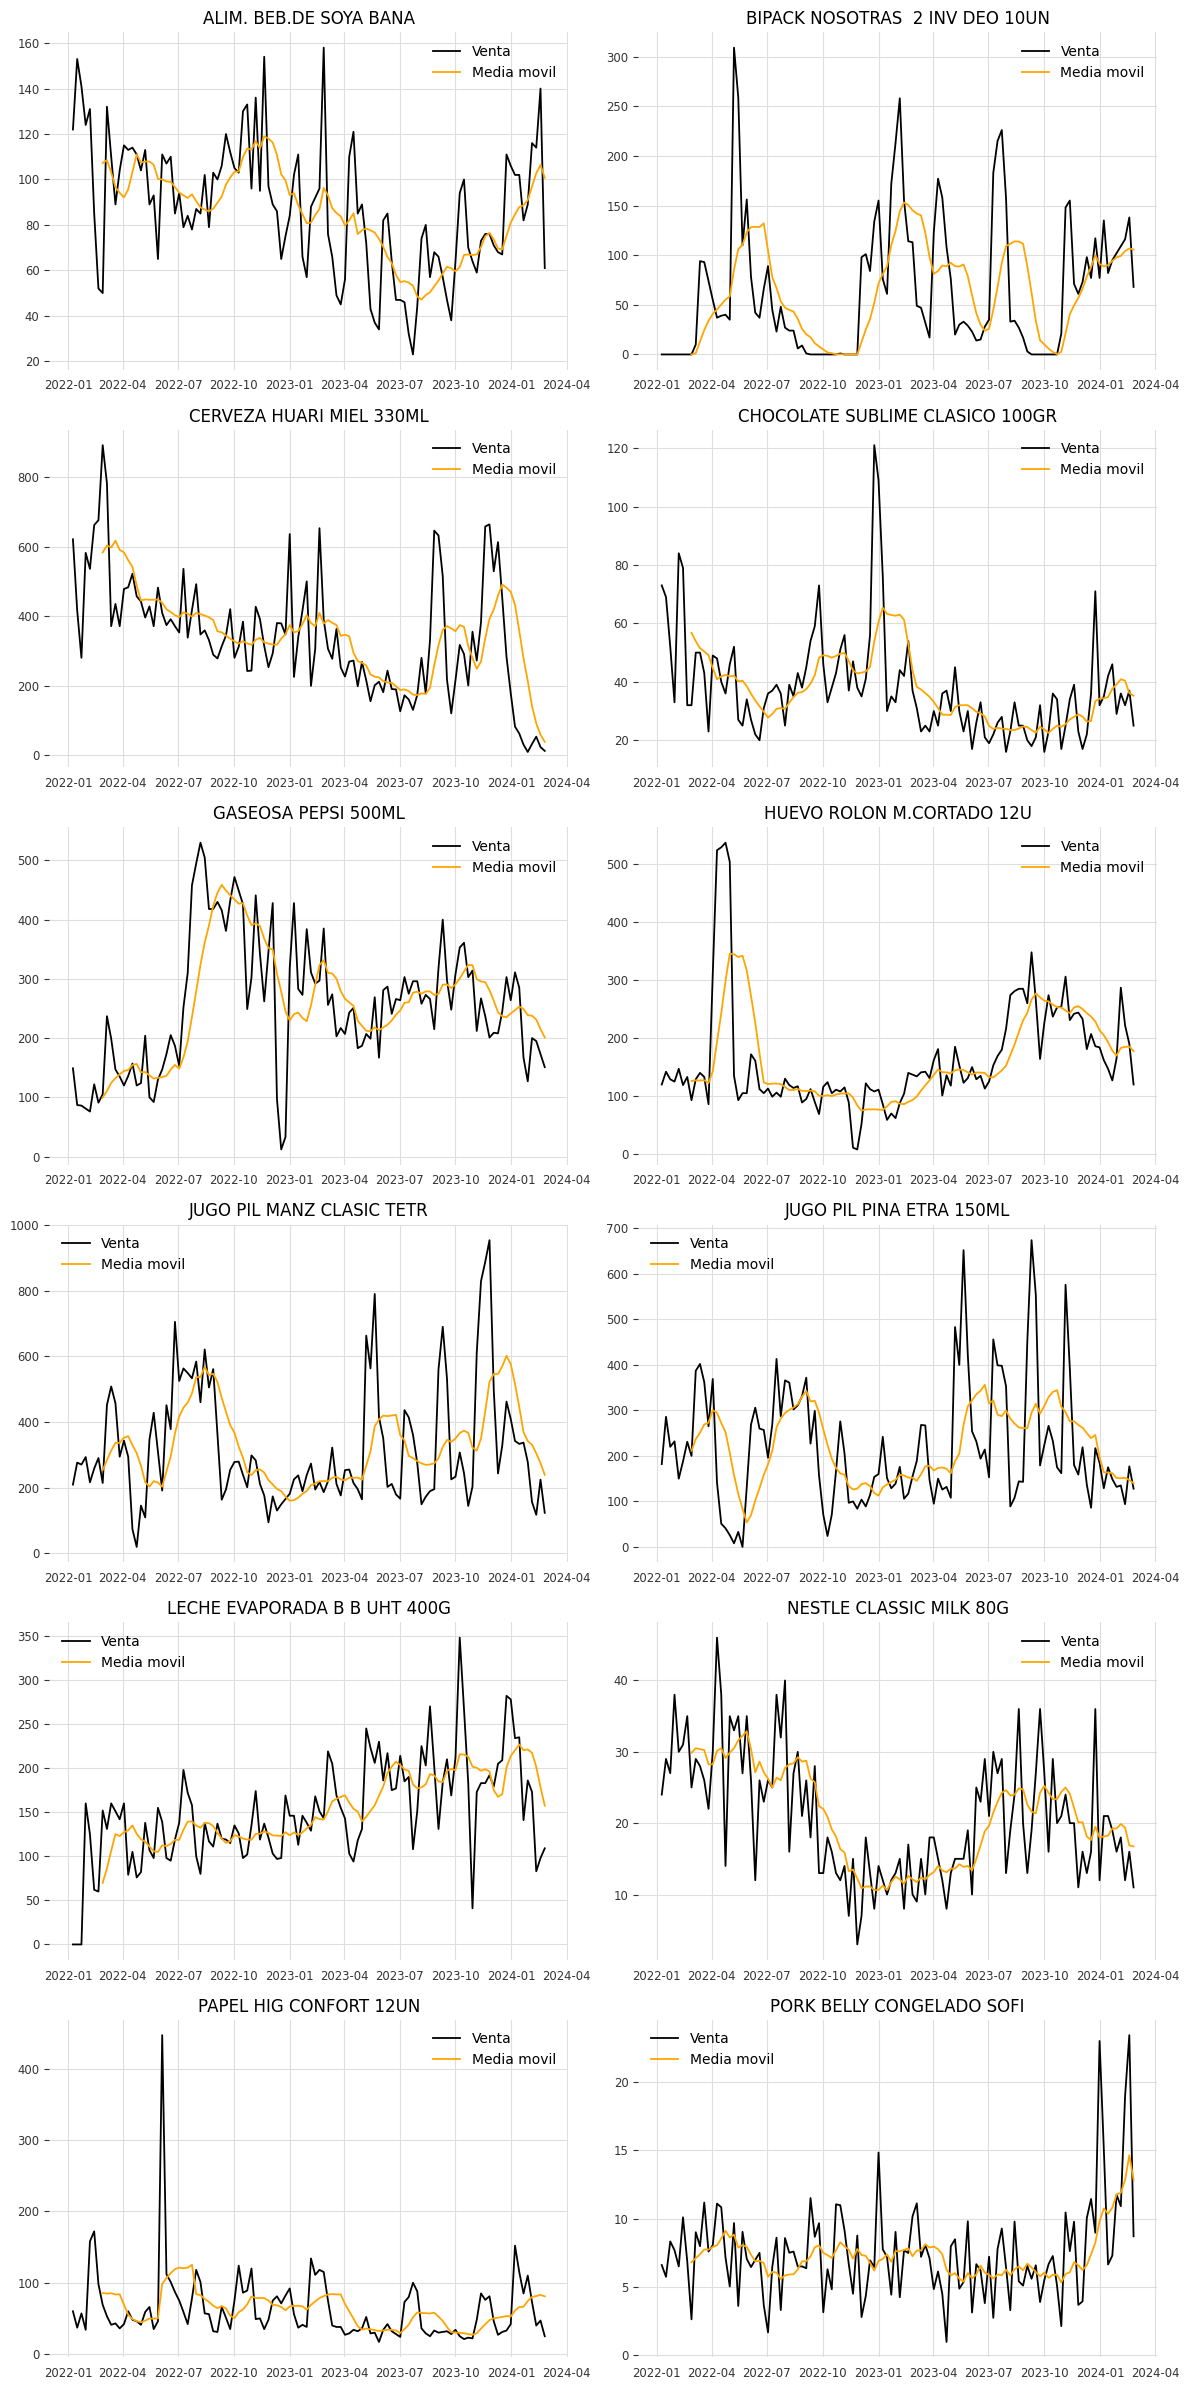

In [26]:
# 3. Predict demand for each product
# 3.1 Plot trends on quantity, by product and week
predictions = {}
df_quantity = df[['Descripcion','Cantidad_Vendida']].pivot_table(
    index=df.index,
    columns='Descripcion',
    values='Cantidad_Vendida',
    aggfunc='sum',
).resample('W', level=0).sum()

print('Figura 3. Cantidad de producto vendido, por semana')
fig, axs = plt.subplots(6,2, figsize=(12,24))
for i, ax in enumerate(axs.flatten()):
    temp_df = df_quantity.iloc[:,i]
    temp_df['rolling'] = temp_df.rolling(8).mean()
    ax.plot(df_quantity.iloc[:,i], label='Venta')
    ax.plot(temp_df['rolling'], c='orange', label='Media movil')
    ax.set_title(df_quantity.columns[i])
    ax.grid(True)
    ax.legend()
    predictions[df_quantity.columns[i]] = round(temp_df['rolling'].iloc[-1],0)
plt.tight_layout()
plt.show()

Las demandas pronosticadas según el procedimiento graficado en la figura 3 
fueron guardadas en un diccionario, de manera que podamos filtrar los 
productos para calcular el mejor nivel de precios.

En esta etapa final, buscaremos el mejor nivel de optimización de precios 
para los productos en base al pronóstico de demanda que hemos hecho en el 
paso anterior. 


In [ ]:
# Step 4. Optimization
# 4.1 Create the function for prediction
def predict_quantity(product, df, elasticity, intercept):
    df_temp = pd.DataFrame()
    ds = df[df['Descripcion']==product].copy()
    ds['Price_Quant'] = ds['Precio_Unitario']* ds['Cantidad_Vendida']
    ds['Avg_Price'] = ds.groupby(ds.index)['Price_Quant'].transform('sum') / ds.groupby(ds.index)['Cantidad_Vendida'].transform('sum')
    # Price range
    start_price = ds[ds['Descripcion']==product]['Avg_Price'].min()
    end_price = ds[ds['Descripcion']==product]['Avg_Price'].max()
    df_temp['price_list'] = np.arange(start_price, end_price, 0.01)
    # Predict quantity
    df_temp['quantity'] =(df_temp['price_list'] - intercept)/elasticity
    df_temp['sales'] = df['Price_Quant']
    return df_temp

In [ ]:
# 4.2 Apply over all our predictions


In [114]:
def predict_quantity(product, df, elasticity, intercept):
    df_temp = pd.DataFrame()
    ds = df[df['Descripcion']==product].copy()
    ds['Price_Quant'] = ds['Precio_Unitario']* ds['Cantidad_Vendida']
    ds['Avg_Price'] = ds.groupby(ds.index)['Price_Quant'].transform('sum') / ds.groupby(ds.index)['Cantidad_Vendida'].transform('sum')
    # Price range
    start_price = ds[ds['Descripcion']==product]['Avg_Price'].min()
    end_price = ds[ds['Descripcion']==product]['Avg_Price'].max()
    df_temp['price_list'] = np.arange(start_price, end_price, 0.01)
    # Predict quantity
    df_temp['quantity'] =(df_temp['price_list'] - intercept)/elasticity
    return df_temp


In [115]:
predict_quantity('ALIM. BEB.DE SOYA BANA', df, -0.007222389088591069, 7.440961158019395)

,price_list,quantity
0,6.00,199.513089
1,6.01,198.128506
2,6.02,196.743922
3,6.03,195.359339
4,6.04,193.974756
...,...,...
145,7.45,-1.251503
146,7.46,-2.636086
147,7.47,-4.020670
148,7.48,-5.405253


In [42]:
predictions

{'ALIM. BEB.DE SOYA BANA': 101.0,
 'BIPACK NOSOTRAS  2 INV DEO 10UN': 106.0,
 'CERVEZA HUARI MIEL 330ML': 39.0,
 'CHOCOLATE SUBLIME CLASICO 100GR': 35.0,
 'GASEOSA PEPSI 500ML': 201.0,
 'HUEVO ROLON M.CORTADO 12U': 178.0,
 'JUGO PIL MANZ CLASIC TETR': 239.0,
 'JUGO PIL PINA ETRA 150ML': 140.0,
 'LECHE EVAPORADA B B UHT 400G': 157.0,
 'NESTLE CLASSIC MILK 80G': 17.0,
 'PAPEL HIG CONFORT 12UN': 81.0,
 'PORK BELLY CONGELADO SOFI': 13.0}

In [37]:
for v,k in enumerate(predictions):
    demand = predictions[k] 
    print(demand)
    intercept = intercepts[k]
    print(intercept)
    elasticity = elasticities[k]
    print(elasticity)
    

101.0
7.440961158019395
-0.007222389088591069
106.0
17.418718475100906
-0.012641207484305573
39.0
11.054607305463065
-0.0009158440305987905
35.0
16.400288346185274
-0.047959432873709865
201.0
4.025656118807223
-0.0006153487405830718
178.0
12.91713678982968
-0.0025859471705274987
239.0
2.0186602235178093
-0.00026106810418714306
140.0
2.003405387372946
-0.00032942972318197167
157.0
6.525415688333881
0.006418765048805285
17.0
15.984341364104308
-0.016093331733224372
81.0
71.00233965104971
-0.08877836200084059
13.0
62.48329596533475
0.02626088852189244


In [96]:
ds = pd.DataFrame({'prod':['A','A','A','B','B'],'quant':[2,3,4,3,1]})
ds

,prod,quant
0,A,2
1,A,3
2,A,4
3,B,3
4,B,1


In [99]:
ds['added_gr'] = ds.groupby('prod')['quant'].transform('sum')

In [100]:
ds

,prod,quant,added_gr
0,A,2,9
1,A,3,9
2,A,4,9
3,B,3,4
4,B,1,4
